### Calcular para cada tickets con cuanto tiempo de antelación se compró

In [1]:
lts = sc.textFile('../../Data/spark/transm150720.csv')

In [2]:
def getTCNFechaCompra(l):
    elems = l.split(",")
    tcn = elems[0]
    fechacompra = elems[9]
    return (tcn, fechacompra)

In [3]:
getTCNFechaCompra(lts.first())

(u'79062005698500', u'141025')

In [4]:
ts = lts.map(getTCNFechaCompra)

In [5]:
ts.take(3)

[(u'79062005698500', u'141025'),
 (u'79062005924069', u'150719'),
 (u'79065668570385', u'150626')]

In [7]:
lcs = sc.textFile('../../Data/spark/coupon150720.csv')

In [8]:
def getTCNFechaSalida(l):
    elems = l.split(",")
    tcn = elems[0]
    fechasalida = elems[12]
    return (tcn, fechasalida)

In [9]:
cs = lcs.map(getTCNFechaSalida)

In [10]:
cs.take(3)

[(u'79062005698500', u'150904'),
 (u'79062005698500', u'150905'),
 (u'79062005924069', u'150721')]

In [ ]:
#Hay claves repetidas, hacemos un group para tener sólo una y quedarnos con la fecha mas antigua.

In [ ]:
#groupbykey hace las agrupaciones de la misma clave en una misma particion en un mismo nodo, 
#por lo que podemos quedarnos sin memoria

In [11]:
cs.groupByKey().mapValues(lambda vs: min(vs)).take(3)

[(u'79062005558463', u'150801'),
 (u'79065668432713', u'150823'),
 (u'79062005501193', u'150720')]

In [15]:
cgps = cs.groupByKey().mapValues(lambda vs: min(vs)).cache()

In [16]:
cgps.take(3)

[(u'79062005558463', u'150801'),
 (u'79065668432713', u'150823'),
 (u'79062005501193', u'150720')]

In [17]:
j = cgps.leftOuterJoin(ts).cache()

In [18]:
j.take(3)

[(u'79062005994272', (u'150720', u'150719')),
 (u'79065668614400', (u'150724', u'150719')),
 (u'79062005501193', (u'150720', u'150719'))]

In [12]:
from time import strptime #convierte texto en fecha
from time import mktime #convierte una fecha en segundos

In [23]:
def difFechas(f1,f2):
    of1 = strptime(f1,'%y%m%d')
    of2 = strptime(f2,'%y%m%d')
    seg1 = mktime(of1)
    seg2 = mktime(of2)
    dif = seg1 - seg2
    return dif/(3600*24)

In [ ]:
#Eliminamos los elementos con fechas vacías, lo deberíamos haber hecho antes

In [21]:
fj = j.filter(lambda x: x[1][0] != '' and x[1][1] != '')

In [22]:
fj.take(3)

[(u'79062005994272', (u'150720', u'150719')),
 (u'79065668614400', (u'150724', u'150719')),
 (u'79062005501193', (u'150720', u'150719'))]

In [24]:
fj.mapValues(lambda v: difFechas(v[0], v[1])).take(3)

[(u'79062005994272', 1.0), (u'79065668614400', 5.0), (u'79062005501193', 1.0)]

In [25]:
d = fj.mapValues(lambda v: difFechas(v[0], v[1]))

In [26]:
d.groupBy(lambda x: x[1]).take(3) # No nos vale, hay que hacerlo con reduceByKey porque pueden salir grupos muy grandes. 
#aparte hay que eliminar los decimales

[(0.0, <pyspark.resultiterable.ResultIterable at 0x7f7da50492d0>),
 (750.0, <pyspark.resultiterable.ResultIterable at 0x7f7da4769610>),
 (198.04166666666666,
  <pyspark.resultiterable.ResultIterable at 0x7f7da4769690>)]

In [27]:
d.map(lambda x: (x[1],1)).take(3)

[(1.0, 1), (5.0, 1), (1.0, 1)]

In [30]:
r = d.map(lambda x: (int(x[1]),1)).reduceByKey(lambda x,acum: x+acum)

In [31]:
r.take(3)

[(0, 28366), (515, 1), (5, 16793)]

In [32]:
r.count()

452

In [33]:
res = r.collect() #recolectamos los datos a una lista

In [34]:
len(res)

452

In [35]:
type(res)

list

In [36]:
res[0:5]

[(0, 28366), (515, 1), (5, 16793), (10, 9906), (15, 7791)]

In [37]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [39]:
xs = [t[0] for t in res]

In [41]:
xs[0:5]

[0, 515, 5, 10, 15]

In [40]:
ys = [t[1] for t in res]

In [42]:
ys[0:5]

[28366, 1, 16793, 9906, 7791]

<Container object of 452 artists>

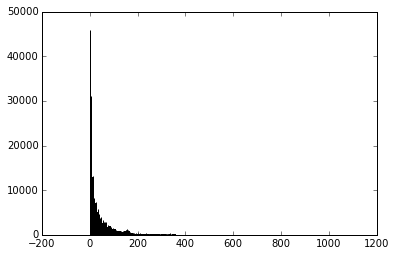

In [43]:
plt.bar(xs,ys)

(0, 90)

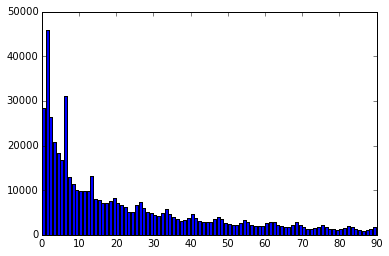

In [48]:
plt.bar(xs,ys)
plt.xlim(0,90)

### Ejercicio. Sacar el precio medio por día de antelacion

In [ ]:
sc.textFile('../../Data/spark/coupon150720.csv').first()

In [ ]:
from time import strptime
from time import mktime

In [ ]:
d1 = strptime('150904' , '%y%m%d')

In [ ]:
d2 = strptime('150623', '%y%m%d')

In [ ]:
(mktime(d1)-mktime(d2))/(3600*24)

In [ ]:
sc.textFile('../../Data/spark/transm150720.csv').first()

In [ ]:
# Sacamos una tabla con TCN,$,Dif. en días fecha compra - fecha salida (min mktime)

In [ ]:
def getTCNDineroFechaSalida(l):
    elems = l.split(",")
    tcn = elems[0]
    dinero = elems[6]
    salida = elems[12]
    return (tcn,salida)

In [ ]:
cs = sc.textFile('../../Data/spark/coupon150720.csv').map(getTCNDineroFechaSalida)
cs.take(3)

In [ ]:
def getTCNFechaCompra(l):
    elems = l.split(",")
    tcn = elems[0]
    venta = elems[9]
    return (tcn,venta)

In [ ]:
ts = sc.textFile('../../Data/spark/transm150720.csv').map(getTCNFechaCompra)
ts.take(3)

In [ ]:
fts = ts.filter(lambda x: x[1] != '')
fcs = cs.filter(lambda x: x[2] != '') 

In [ ]:
def fechaMenor(ds):
    segs = [mktime(strptime(d, '%y%m%d')) for d in ds]
    #print [segs for segs in ds]
    return min(segs)

In [ ]:
fts.cogroup(fcs).cache()

In [ ]:
fts.cogroup(fcs).mapValues(lambda x: ((fechaMenor(x[1]),fechaMenor(x[0]))).take(1))

In [ ]:
fts.cogroup(fcs).mapValues(lambda x: (fechaMenor(x[1])-fechaMenor(x[0]))).take(1)

In [ ]:
r = fts.cogroup(fcs).mapValues(lambda x: (fechaMenor(x[1])-fechaMenor(x[0])))

In [ ]:
r.take(2)

In [ ]:
r.mapValues(lambda dif: dif/(3600*24)).map(lambda x: (int(x[1]),1)).reduceByKey(lambda x,y: x+y)